In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import shap

c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# no past_proficient_score

In [2]:
scantronReading_38_encoded_df = pd.read_csv('../dataframes/scantronReading_38_encoded.csv')
scantronReading_38_encoded_df.head()

,studentId,level,dataSource,is_proficient,proficient_score,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,...,past_proficient_score,subject_math,subject_reading,subject_science,subject_social-studies,subject_music,subject_art,subject_performing-arts,subject_phys-ed,subject_career-prep
0,44777,7,value_scantronReading,False,0.993342,False,False,False,False,False,...,0.969279,2,2,2,2,1,0,0,0,0
1,44783,7,value_scantronReading,False,0.997179,False,False,False,False,False,...,1.009665,2,2,2,1,0,0,0,0,0
2,44784,6,value_scantronReading,False,0.947277,False,False,False,False,False,...,0.934354,2,2,2,2,1,0,0,0,0
3,44807,7,value_scantronReading,True,1.014669,False,False,False,False,False,...,1.028650,2,2,1,2,0,0,0,0,0
4,44809,7,value_scantronReading,False,0.934665,False,False,False,False,False,...,0.949085,2,2,2,2,1,0,0,0,0


In [3]:
X = scantronReading_38_encoded_df.drop(['studentId', 'dataSource', 'is_proficient', 'proficient_score', 'level', 'past_proficient_score'], axis=1)
y = scantronReading_38_encoded_df['proficient_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=scantronReading_38_encoded_df['is_proficient'])

In [4]:
rf_best_params = {'max_depth': 5, 'n_estimators': 100}

In [5]:
max_depth = [5,15, 30]
n_estimators = [100,250,400]
param_grid = {'max_depth' : list(max_depth), 'n_estimators' : list(n_estimators)}

In [6]:
# Grid Search to find the best hyperparameters 

print("Running Grid Search")
rf_regressor = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_train, y_train)

print("Done")
rf_best_params = rf_grid_search.best_params_

rf_best_params

Running Grid Search


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Done


{'max_depth': 5, 'n_estimators': 400}

In [7]:
print('Begin Random Forest ')
rf_model = RandomForestRegressor(max_depth=5, n_estimators=400)
rf_model.fit(X_train,y_train)
print('End')

Begin Random Forest 


End


In [8]:
y_pred_continuous = rf_model.predict(X_test)
rsme = mean_squared_error(y_test, y_pred_continuous, squared=False)
r2 = r2_score(y_test, y_pred_continuous)


threshold = 1.1  # ADJUST
y_pred_bool = y_pred_continuous >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool))


print('[RF] Root Mean Squared Error: {0}'.format(rsme))
print('[RF] R2: {0}'.format(r2))        

threshold= 1.1

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98      3912
        True       0.00      0.00      0.00       180

    accuracy                           0.96      4092
   macro avg       0.48      0.50      0.49      4092
weighted avg       0.91      0.96      0.93      4092


Confusion Matrix:
[[3912    0]
 [ 180    0]]
[RF] Root Mean Squared Error: 0.11386884045606649
[RF] R2: 0.0031039763837832357


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\l

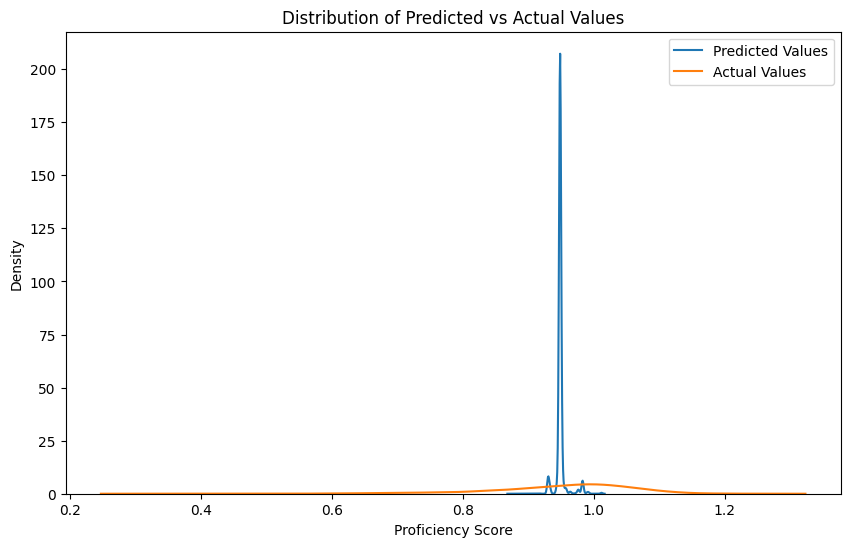

In [9]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=y_pred_continuous, label='Predicted Values')
sns.kdeplot(data=y_test, label='Actual Values')
plt.title('Distribution of Predicted vs Actual Values')
plt.xlabel('Proficiency Score')
plt.ylabel('Density')
plt.legend()
plt.show()

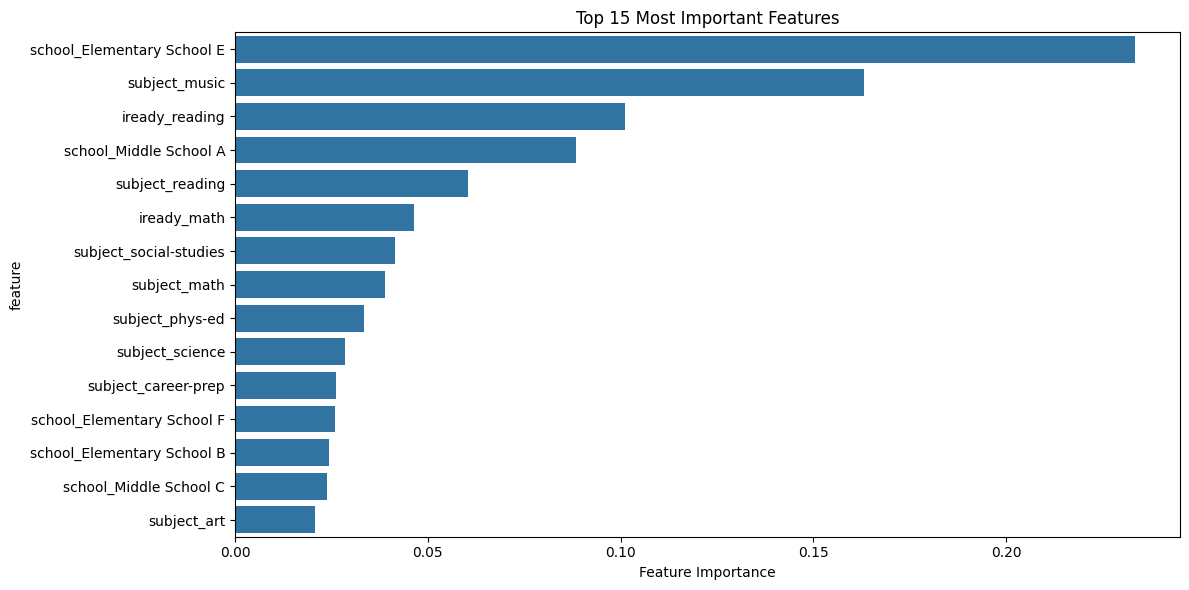


Feature Importance Scores:
                         feature  importance
2     school_Elementary School E    0.233424
15                 subject_music    0.163224
10                iready_reading    0.101169
5         school_Middle School A    0.088467
12               subject_reading    0.060488
9                    iready_math    0.046392
14        subject_social-studies    0.041502
11                  subject_math    0.038986
18               subject_phys-ed    0.033452
13               subject_science    0.028426
19           subject_career-prep    0.026067
3     school_Elementary School F    0.025825
1     school_Elementary School B    0.024428
6         school_Middle School C    0.023751
16                   subject_art    0.020685
7         school_Middle School D    0.016177
8         school_Middle School F    0.014967
0            school_Elementary A    0.009801
4   school_Intermediate School E    0.002476
17       subject_performing-arts    0.000293


In [10]:
# Get feature importance scores
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print feature importance scores
print("\nFeature Importance Scores:")
print(feature_importance)


# w/ past_proficient_score

In [11]:
scantronReading_38_encoded_df = pd.read_csv('../dataframes/scantronReading_38_encoded.csv')
scantronReading_38_encoded_df.head()

,studentId,level,dataSource,is_proficient,proficient_score,school_Elementary A,school_Elementary School B,school_Elementary School E,school_Elementary School F,school_Intermediate School E,...,past_proficient_score,subject_math,subject_reading,subject_science,subject_social-studies,subject_music,subject_art,subject_performing-arts,subject_phys-ed,subject_career-prep
0,44777,7,value_scantronReading,False,0.993342,False,False,False,False,False,...,0.969279,2,2,2,2,1,0,0,0,0
1,44783,7,value_scantronReading,False,0.997179,False,False,False,False,False,...,1.009665,2,2,2,1,0,0,0,0,0
2,44784,6,value_scantronReading,False,0.947277,False,False,False,False,False,...,0.934354,2,2,2,2,1,0,0,0,0
3,44807,7,value_scantronReading,True,1.014669,False,False,False,False,False,...,1.028650,2,2,1,2,0,0,0,0,0
4,44809,7,value_scantronReading,False,0.934665,False,False,False,False,False,...,0.949085,2,2,2,2,1,0,0,0,0


In [12]:
X = scantronReading_38_encoded_df.drop(['studentId', 'dataSource', 'is_proficient', 'proficient_score', 'level'], axis=1)
y = scantronReading_38_encoded_df['proficient_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=scantronReading_38_encoded_df['is_proficient'])

Baseline for using past proficiency

In [13]:
X = scantronReading_38_encoded_df
y = scantronReading_38_encoded_df[['proficient_score', 'past_proficient_score']]

# Perform train-test split, retaining is_proficient in the test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=123, 
    stratify=scantronReading_38_encoded_df['is_proficient']
)

print("Not proficient to proficient")
print(sum((y_test['past_proficient_score'] < 1) & (y_test['proficient_score'] > 1)))

print("Proficient to not proficient")
print(sum((y_test['past_proficient_score'] >= 1) & (y_test['proficient_score'] < 1)))

print("Size of test set")
print(y_test.shape)

X = scantronReading_38_encoded_df.drop(['studentId', 'dataSource', 'is_proficient', 'proficient_score', 'level'], axis=1)
y = scantronReading_38_encoded_df['proficient_score']


Not proficient to proficient
306
Proficient to not proficient
131
Size of test set
(4092, 2)


In [14]:
# Count rows where student was not proficient but had past proficient score > 1
print("Not proficient to proficient")
print(len(X_test[(scantronReading_38_encoded_df['is_proficient'] == False) & 
                                 (y_test['proficient_score'] > 1)]))

# Count rows where student ends up proficient but had past proficient score < 1
print("Proficient to not proficient")
print(len(scantronReading_38_encoded_df[(scantronReading_38_encoded_df['is_proficient'] == True) & 
                                 (scantronReading_38_encoded_df['past_proficient_score'] < 1)]))


Not proficient to proficient
0
Proficient to not proficient
1433


C:\Users\lmmag\AppData\Local\Temp\ipykernel_56300\2132041011.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(X_test[(scantronReading_38_encoded_df['is_proficient'] == False) &


In [15]:
1 - ((619 + 1433)/20460)

0.8997067448680351

In [16]:
max_depth = [5,15, 30]
n_estimators = [100,250,400]
param_grid = {'max_depth' : list(max_depth), 'n_estimators' : list(n_estimators)}

In [17]:
# Grid Search to find the best hyperparameters 
print("Running Grid Search")
rf_regressor = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_grid = GridSearchCV(rf_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_search = rf_grid.fit(X_train, y_train)

print("Done")
rf_best_params = rf_grid_search.best_params_

rf_best_params


Running Grid Search


ValueError: 
All the 27 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_forest.py", line 363, in fit
    X, y = self._validate_data(
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py", line 1301, in check_X_y
    X = check_array(
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py", line 929, in check_array
    array = array.astype(new_dtype)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\managers.py", line 430, in astype
    return self.apply(
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\internals\blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
  File "c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
ValueError: could not convert string to float: 'value_scantronReading'


In [ ]:
print('Begin Random Forest ')
rf_model = RandomForestRegressor(max_depth=5, n_estimators=400)
rf_model.fit(X_train,y_train)
print('End')

Begin Random Forest 


ValueError: could not convert string to float: 'value_scantronReading'

In [ ]:
y_pred_continuous = rf_model.predict(X_test)
rsme = mean_squared_error(y_test, y_pred_continuous, squared=False)
r2 = r2_score(y_test, y_pred_continuous)


threshold = 1.1  # ADJUST
y_pred_bool = y_pred_continuous >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool))


print('[RF] Root Mean Squared Error: {0}'.format(rsme))
print('[RF] R2: {0}'.format(r2))        

AttributeError: 'RandomForestRegressor' object has no attribute 'estimators_'

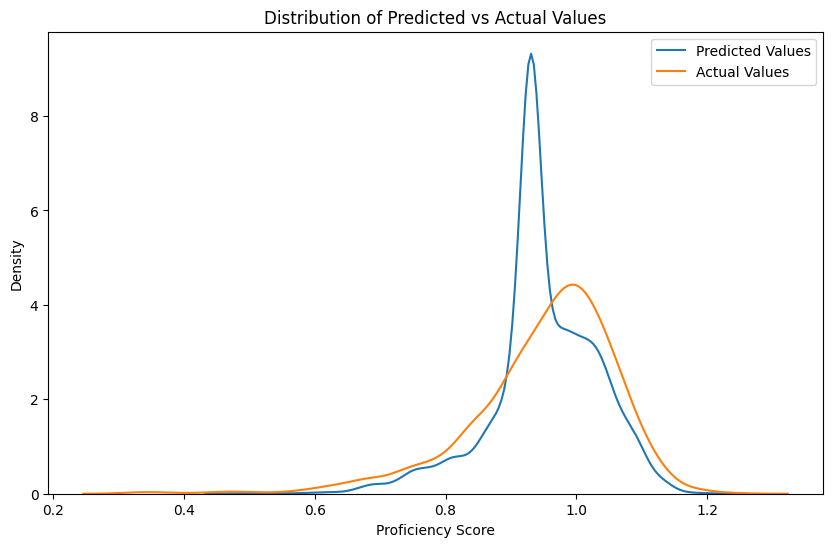

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=y_pred_continuous, label='Predicted Values')
sns.kdeplot(data=y_test, label='Actual Values')
plt.title('Distribution of Predicted vs Actual Values')
plt.xlabel('Proficiency Score')
plt.ylabel('Density')
plt.legend()
plt.show()

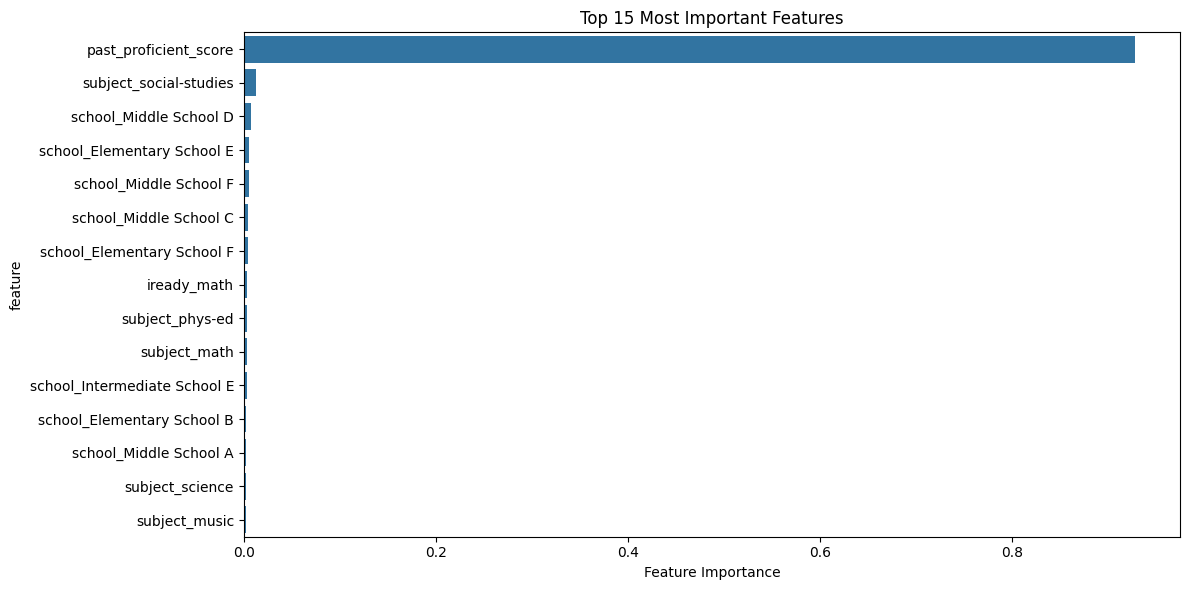


Feature Importance Scores:
                         feature  importance
11         past_proficient_score    0.928396
15        subject_social-studies    0.012420
7         school_Middle School D    0.007471
2     school_Elementary School E    0.005531
8         school_Middle School F    0.005462
6         school_Middle School C    0.004556
3     school_Elementary School F    0.004198
9                    iready_math    0.003848
19               subject_phys-ed    0.003702
12                  subject_math    0.003477
4   school_Intermediate School E    0.003278
1     school_Elementary School B    0.002559
5         school_Middle School A    0.002545
14               subject_science    0.002366
16                 subject_music    0.002343
13               subject_reading    0.001995
17                   subject_art    0.001831
10                iready_reading    0.001807
0            school_Elementary A    0.001791
20           subject_career-prep    0.000382
18       subject_performing

In [ ]:
# Get feature importance scores
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})

# Sort features by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print feature importance scores
print("\nFeature Importance Scores:")
print(feature_importance)


SHAP